In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.raster_helper_functions import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
gravity_anomaly_file, gravity_anomaly_data = read_raster_file('tif_files/ANTGG_BouguerAnomaly_10km.tif')
bed_file, bed_data = read_raster_file('tif_files/bedmap2_bed.tif')
bed_resample_data = resample_raster(bed_file, bed_data, gravity_anomaly_file)
df_bouguer = get_df(gravity_anomaly_file, gravity_anomaly_data, 'gravity_anomaly')
df_bouguer['bedmap_bed'] = bed_resample_data.flatten()
df_bouguer = df_bouguer[df_bouguer['gravity_anomaly'] >= -500]

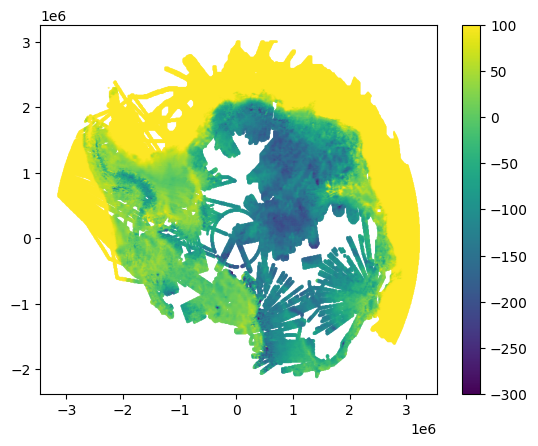

In [8]:
scatter_plot = plt.scatter(df_bouguer['x'], df_bouguer['y'], c=df_bouguer['gravity_anomaly'], s = 0.1)
plt.colorbar(scatter_plot)
plt.clim(-300, 100)

In [9]:
free_air_anomaly_file, free_air_anomaly_data = read_raster_file('tif_files/ANTGG_FreeAirGravityAnomaly_10km.tif')
bed_resample_data = resample_raster(bed_file, bed_data, free_air_anomaly_file)
df_free_air = get_df(free_air_anomaly_file, free_air_anomaly_data, 'free_air_gravity_anomaly')
df_free_air['bedmap_bed'] = bed_resample_data.flatten()
df_free_air = df_free_air[df_free_air['free_air_gravity_anomaly'] >= -500]

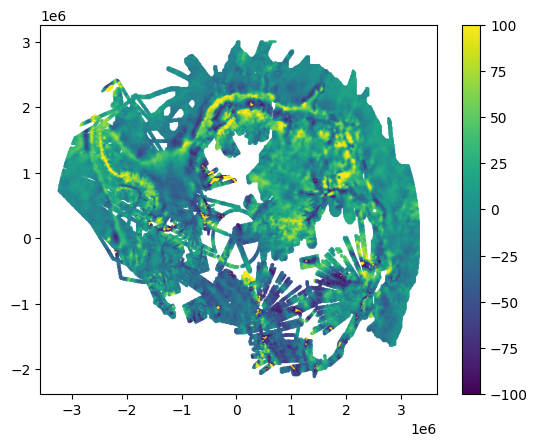

In [10]:
scatter_plot = plt.scatter(df_free_air['x'], df_free_air['y'], c=df_free_air['free_air_gravity_anomaly'], s=0.1)
plt.colorbar(scatter_plot)
plt.clim(-100, 100)

In [12]:
gravity_disturbance_file, gravity_disturbance_data = read_raster_file('tif_files/EIGEN-6C4_GravityDisturbance_10km.tif')
bed_resample_data = resample_raster(bed_file, bed_data, gravity_disturbance_file)
df_gravity_disturbance = get_df(gravity_disturbance_file, gravity_disturbance_data, 'gravity_disturbance')
df_gravity_disturbance['bedmap_bed'] = bed_resample_data.flatten()
df_gravity_disturbance = df_gravity_disturbance[df_gravity_disturbance['gravity_disturbance'] >= -500]

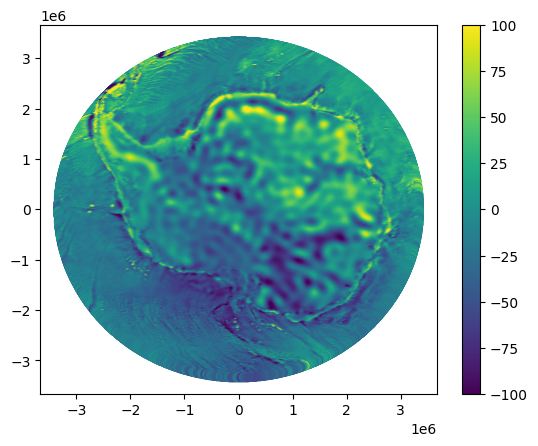

In [13]:
scatter_plot = plt.scatter(df_gravity_disturbance['x'], df_gravity_disturbance['y'], c=df_gravity_disturbance['gravity_disturbance'])
plt.colorbar(scatter_plot)
plt.clim(-100, 100)

In [14]:
print(df_free_air.shape, df_gravity_disturbance.shape)

(181414, 4) (350248, 4)


In [15]:
# Prepare data for multi-fidelity model

input_columns = ['x', 'y', 'bedmap_bed']
# High fidelity data
#X_high = df_free_air[input_columns].values
#Y_high = df_free_air['free_air_gravity_anomaly'].values.reshape(-1, 1)

X_high = df_bouguer[input_columns].values
Y_high = df_bouguer['gravity_anomaly'].values.reshape(-1, 1)

# Low fidelity data
X_low = df_gravity_disturbance[input_columns].values
Y_low = df_gravity_disturbance['gravity_disturbance'].values.reshape(-1, 1)

# Split data into train and test sets
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low, Y_low, test_size=0.2, random_state=42)
X_high_train, X_high_test, Y_high_train, Y_high_test = train_test_split(X_high, Y_high, test_size=0.2, random_state=42)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=70, min_lr=0.00001) # 40
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=150, #100
    restore_best_weights=True)

In [17]:
# Define low fidelity model
neurons = 100 # Number of neurons in each hidden layer
input_low = Input(shape=(len(input_columns),), name='low_fidelity_input')
x_low = Dense(neurons, activation='relu')(input_low)
for _ in range(20):
    x_low = Dense(neurons, activation='relu')(x_low)
output_low = Dense(1, name='low_fidelity_output')(x_low)
model_low = Model(inputs=input_low, outputs=output_low)

# Compile low fidelity model
model_low.compile(optimizer='adam', loss='mse')

# Train low fidelity model
history_low = model_low.fit(X_low_train, Y_low_train, epochs=500, batch_size=128, verbose=1, validation_split=0.1, shuffle=True, callbacks=[reduce_lr, early_stopping])


# Predict high fidelity values at low fidelity points using the low fidelity model
low_fidelity_predictions_train = model_low.predict(X_low_train)
low_fidelity_predictions_test = model_low.predict(X_low_test)

r2 = r2_score(low_fidelity_predictions_test, Y_low_test)

Epoch 1/500
1971/1971 [==============================] - 32s 16ms/step - loss: 780.5395 - val_loss: 640.4623 - lr: 0.0010
Epoch 2/500
1971/1971 [==============================] - 33s 17ms/step - loss: 603.4157 - val_loss: 591.3239 - lr: 0.0010
Epoch 3/500
1971/1971 [==============================] - 29s 15ms/step - loss: 578.6193 - val_loss: 577.7125 - lr: 0.0010
Epoch 4/500
1971/1971 [==============================] - 31s 16ms/step - loss: 535.9208 - val_loss: 518.3552 - lr: 0.0010
Epoch 5/500
1971/1971 [==============================] - 33s 17ms/step - loss: 477.6815 - val_loss: 465.5682 - lr: 0.0010
Epoch 6/500
1971/1971 [==============================] - 33s 17ms/step - loss: 445.9484 - val_loss: 554.7430 - lr: 0.0010
Epoch 7/500
1971/1971 [==============================] - 33s 17ms/step - loss: 420.3191 - val_loss: 397.9826 - lr: 0.0010
Epoch 8/500
1971/1971 [==============================] - 32s 16ms/step - loss: 389.0208 - val_loss: 409.3734 - lr: 0.0010
Epoch 9/500
1971/1971 [=

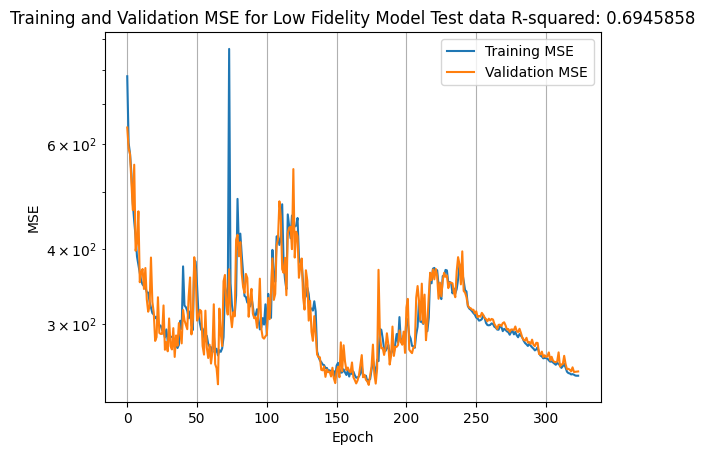

In [18]:
# Plot training and validation loss
plt.grid()
plt.semilogy(history_low.history['loss'], label='Training MSE')
plt.semilogy(history_low.history['val_loss'], label='Validation MSE')
plt.title('Training and Validation MSE for Low Fidelity Model' + ' Test data R-squared: {:.7f}'.format(r2))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [19]:
# Define high fidelity model
neurons = 100   # Number of neurons in each hidden layer
input_high = Input(shape=(len(input_columns),), name='high_fidelity_input')
x_high = Dense(neurons, activation='relu')(input_high)
for _ in range(20):
    x_high = Dense(neurons, activation='relu')(x_high)
output_high = Dense(1, name='high_fidelity_output')(x_high)
model_high = Model(inputs=input_high, outputs=output_high)

# Compile high fidelity model
model_high.compile(optimizer='adam', loss='mse')

# Train high fidelity model
history_high = model_high.fit(X_high_train, Y_high_train, epochs=500, batch_size=128, verbose=1, validation_split=0.1, shuffle=True, callbacks=[reduce_lr, early_stopping])

high_fidelity_predictions_train_hf = model_high.predict(X_high_train)
high_fidelity_predictions_test_hf = model_high.predict(X_high_test)

low_fidelity_predictions_train_hf = model_high.predict(X_low_train)
low_fidelity_predictions_test_hf = model_high.predict(X_low_test)

r2 = r2_score(high_fidelity_predictions_test_hf, Y_high_test)

Epoch 1/500
999/999 [==============================] - 19s 17ms/step - loss: 15351.3926 - val_loss: 14064.6572 - lr: 0.0010
Epoch 2/500
999/999 [==============================] - 17s 17ms/step - loss: 5009.9614 - val_loss: 1175.1222 - lr: 0.0010
Epoch 3/500
999/999 [==============================] - 17s 17ms/step - loss: 1118.3568 - val_loss: 906.2852 - lr: 0.0010
Epoch 4/500
999/999 [==============================] - 17s 17ms/step - loss: 937.5530 - val_loss: 686.4443 - lr: 0.0010
Epoch 5/500
999/999 [==============================] - 17s 17ms/step - loss: 878.5034 - val_loss: 831.2191 - lr: 0.0010
Epoch 6/500
999/999 [==============================] - 17s 17ms/step - loss: 790.6160 - val_loss: 803.9379 - lr: 0.0010
Epoch 7/500
999/999 [==============================] - 17s 17ms/step - loss: 727.8477 - val_loss: 609.7772 - lr: 0.0010
Epoch 8/500
999/999 [==============================] - 17s 17ms/step - loss: 695.7982 - val_loss: 645.3168 - lr: 0.0010
Epoch 9/500
999/999 [============

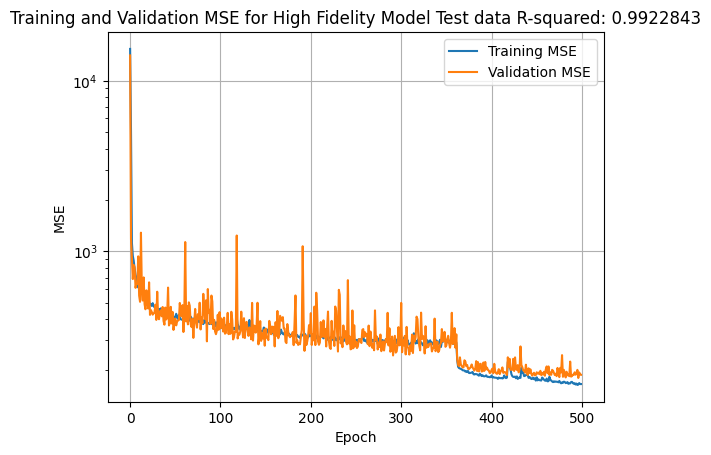

In [20]:
# Plot training and validation loss
plt.grid()
plt.semilogy(history_high.history['loss'], label='Training MSE')
plt.semilogy(history_high.history['val_loss'], label='Validation MSE')
plt.title('Training and Validation MSE for High Fidelity Model'+ ' Test data R-squared: {:.7f}'.format(r2))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [21]:
high_fidelity_predictions_train = model_low.predict(X_high_train)
high_fidelity_predictions_test = model_low.predict(X_high_test)

# Combine low fidelity predictions with high fidelity inputs
combined_input_train = np.hstack([X_high_train, high_fidelity_predictions_train])
combined_input_test = np.hstack([X_high_test, high_fidelity_predictions_test])

# Redefine high fidelity model with additional input from low fidelity predictions
neurons = 100 # Number of neurons in each hidden layer
input_combined = Input(shape=(len(input_columns)+1,), name='combined_input')
x_combined = Dense(neurons, activation='relu')(input_combined)
for _ in range(20):
    x_combined = Dense(neurons, activation='relu')(x_combined)
output_combined = Dense(1, name='combined_output')(x_combined)
model_combined = Model(inputs=input_combined, outputs=output_combined)

# Compile combined model
model_combined.compile(optimizer='adam', loss='mse')

# Train combined model with combined inputs
history_combined = model_combined.fit(combined_input_train, Y_high_train, epochs=500, batch_size=128, verbose=1, validation_split=0.1, shuffle=True, callbacks=[reduce_lr, early_stopping])

# Predict high fidelity at low fidelity points using the combined model
final_predictions_train = model_combined.predict(np.hstack([X_low_train, low_fidelity_predictions_train]))
final_predictions_test = model_combined.predict(np.hstack([X_low_test, low_fidelity_predictions_test]))

final_predictions_test_high = model_combined.predict(np.hstack([X_high_test, high_fidelity_predictions_test]))
final_predictions_train_high = model_combined.predict(np.hstack([X_high_train, high_fidelity_predictions_train]))

r2_low = r2_score(final_predictions_test, Y_low_test)
r2_high = r2_score(final_predictions_test_high, Y_high_test)

1110/1110 [==============================] - 6s 6ms/step
Epoch 1/500
999/999 [==============================] - 19s 18ms/step - loss: 15969.6025 - val_loss: 13377.9697 - lr: 0.0010
Epoch 2/500
999/999 [==============================] - 18s 18ms/step - loss: 9735.7402 - val_loss: 2405.0374 - lr: 0.0010
Epoch 3/500
999/999 [==============================] - 18s 18ms/step - loss: 1771.4009 - val_loss: 976.1034 - lr: 0.0010
Epoch 4/500
999/999 [==============================] - 18s 18ms/step - loss: 1339.4918 - val_loss: 1175.0317 - lr: 0.0010
Epoch 5/500
999/999 [==============================] - 18s 18ms/step - loss: 866.0304 - val_loss: 943.8033 - lr: 0.0010
Epoch 6/500
999/999 [==============================] - 17s 17ms/step - loss: 841.1863 - val_loss: 1140.0735 - lr: 0.0010
Epoch 7/500
999/999 [==============================] - 18s 18ms/step - loss: 767.6021 - val_loss: 606.4552 - lr: 0.0010
Epoch 8/500
999/999 [==============================] - 18s 18ms/step - loss: 709.6985 - val_l

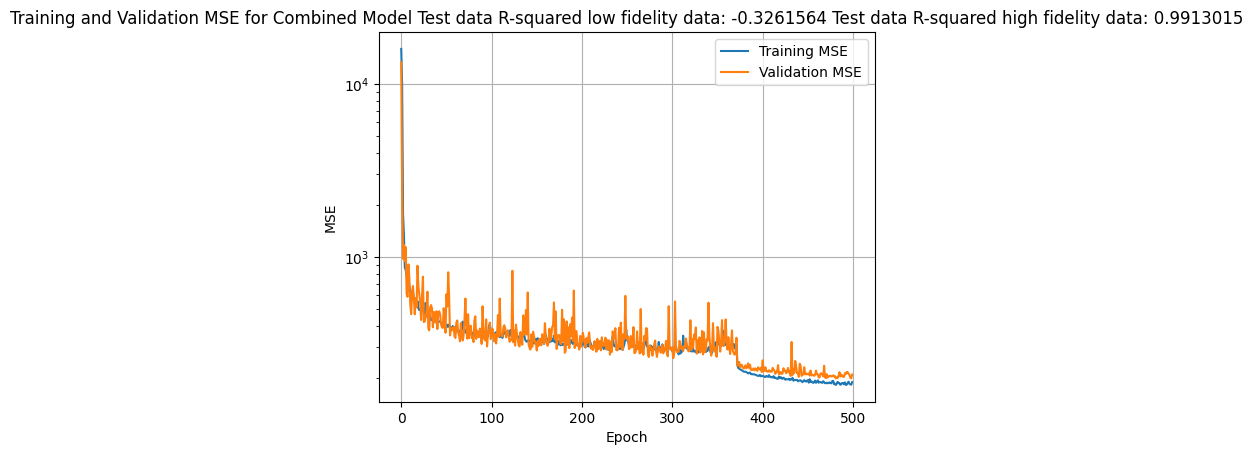

In [22]:
# Plot training and validation loss
plt.grid()
plt.semilogy(history_combined.history['loss'], label='Training MSE')
plt.semilogy(history_combined.history['val_loss'], label='Validation MSE')
plt.title('Training and Validation MSE for Combined Model' + ' Test data R-squared low fidelity data: {:.7f}'.format(r2_low) + ' Test data R-squared high fidelity data: {:.7f}'.format(r2_high))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

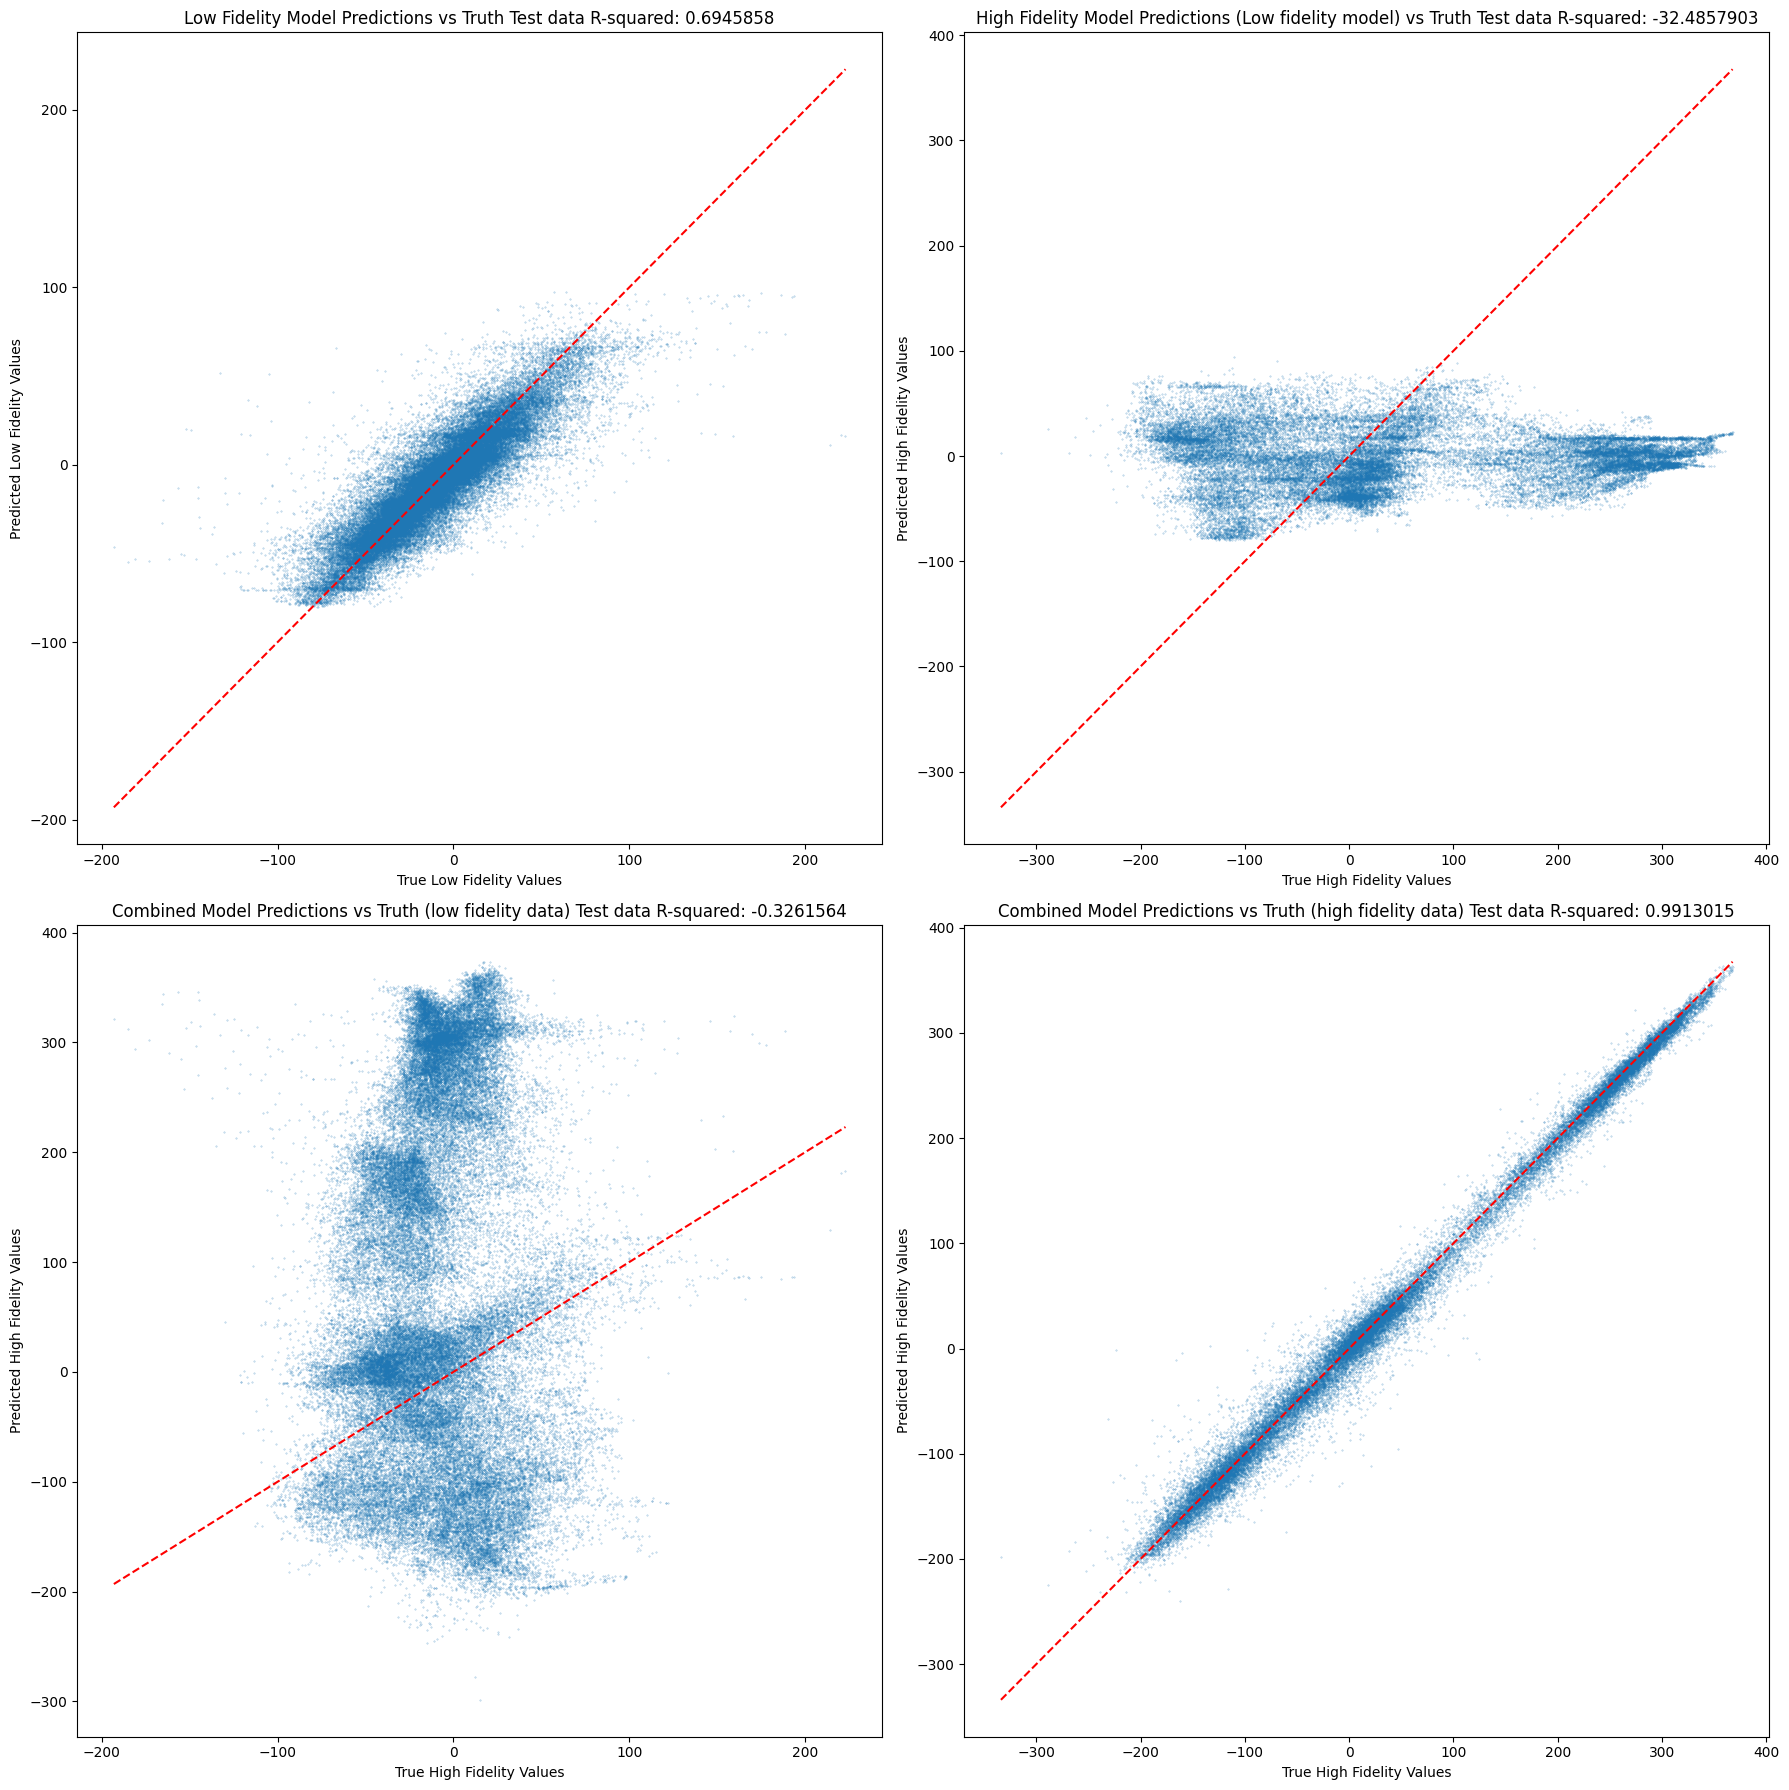

In [23]:
# Plotting predictions vs truth for low fidelity model
plt.figure(figsize=(18, 18))

plt.subplot(2, 2, 1)
r2 = r2_score(low_fidelity_predictions_test, Y_low_test)
plt.scatter(Y_low_test, low_fidelity_predictions_test, alpha=0.5, s= 0.1)
plt.plot([min(Y_low_test), max(Y_low_test)], [min(Y_low_test), max(Y_low_test)], color='red', linestyle='--')
plt.xlabel('True Low Fidelity Values')
plt.ylabel('Predicted Low Fidelity Values')
plt.title('Low Fidelity Model Predictions vs Truth' + ' Test data R-squared: {:.7f}'.format(r2))

# Plotting predictions vs truth for high fidelity model
plt.subplot(2, 2, 2)
r2 = r2_score(high_fidelity_predictions_test, Y_high_test)
plt.scatter(Y_high_test, high_fidelity_predictions_test, alpha=0.5, s= 0.1)
plt.plot([min(Y_high_test), max(Y_high_test)], [min(Y_high_test), max(Y_high_test)], color='red', linestyle='--')
plt.xlabel('True High Fidelity Values')
plt.ylabel('Predicted High Fidelity Values')
plt.title('High Fidelity Model Predictions (Low fidelity model) vs Truth' + ' Test data R-squared: {:.7f}'.format(r2))

# # Plotting predictions vs truth for high fidelity model
# plt.subplot(2, 3, 3)
# plt.scatter(Y_high_test, high_fidelity_predictions_test_00, alpha=0.5, s= 0.1)
# plt.xlabel('True High Fidelity Values')
# plt.ylabel('Predicted High Fidelity Values')
# plt.title('High Fidelity Model Predictions (High fidelity model) vs Truth')

# Plotting predictions vs truth for combined model
plt.subplot(2, 2, 3)
r2 = r2_score(final_predictions_test, Y_low_test)
plt.scatter(Y_low_test, final_predictions_test, alpha=0.5, s= 0.1)
plt.plot([min(Y_low_test), max(Y_low_test)], [min(Y_low_test), max(Y_low_test)], color='red', linestyle='--')
plt.xlabel('True High Fidelity Values')
plt.ylabel('Predicted High Fidelity Values')
plt.title('Combined Model Predictions vs Truth (low fidelity data)' + ' Test data R-squared: {:.7f}'.format(r2))

# Plotting predictions vs truth for combined model
plt.subplot(2, 2, 4)
r2 = r2_score(final_predictions_test_high, Y_high_test)
plt.scatter(Y_high_test, final_predictions_test_high, alpha=0.5, s= 0.1)
plt.plot([min(Y_high_test), max(Y_high_test)], [min(Y_high_test), max(Y_high_test)], color='red', linestyle='--')
plt.xlabel('True High Fidelity Values')
plt.xlabel('True High Fidelity Values')
plt.ylabel('Predicted High Fidelity Values')
plt.title('Combined Model Predictions vs Truth (high fidelity data)' + ' Test data R-squared: {:.7f}'.format(r2))

plt.tight_layout()
plt.show()

Mean Error Single-fidelity Model (Train): 8.801722
Mean Error Single-fidelity Model: (Test): 9.116675
Mean Error Multifidelity Model (Train): 9.481985
Mean Error Multifidelity Model: (Test): 9.712069


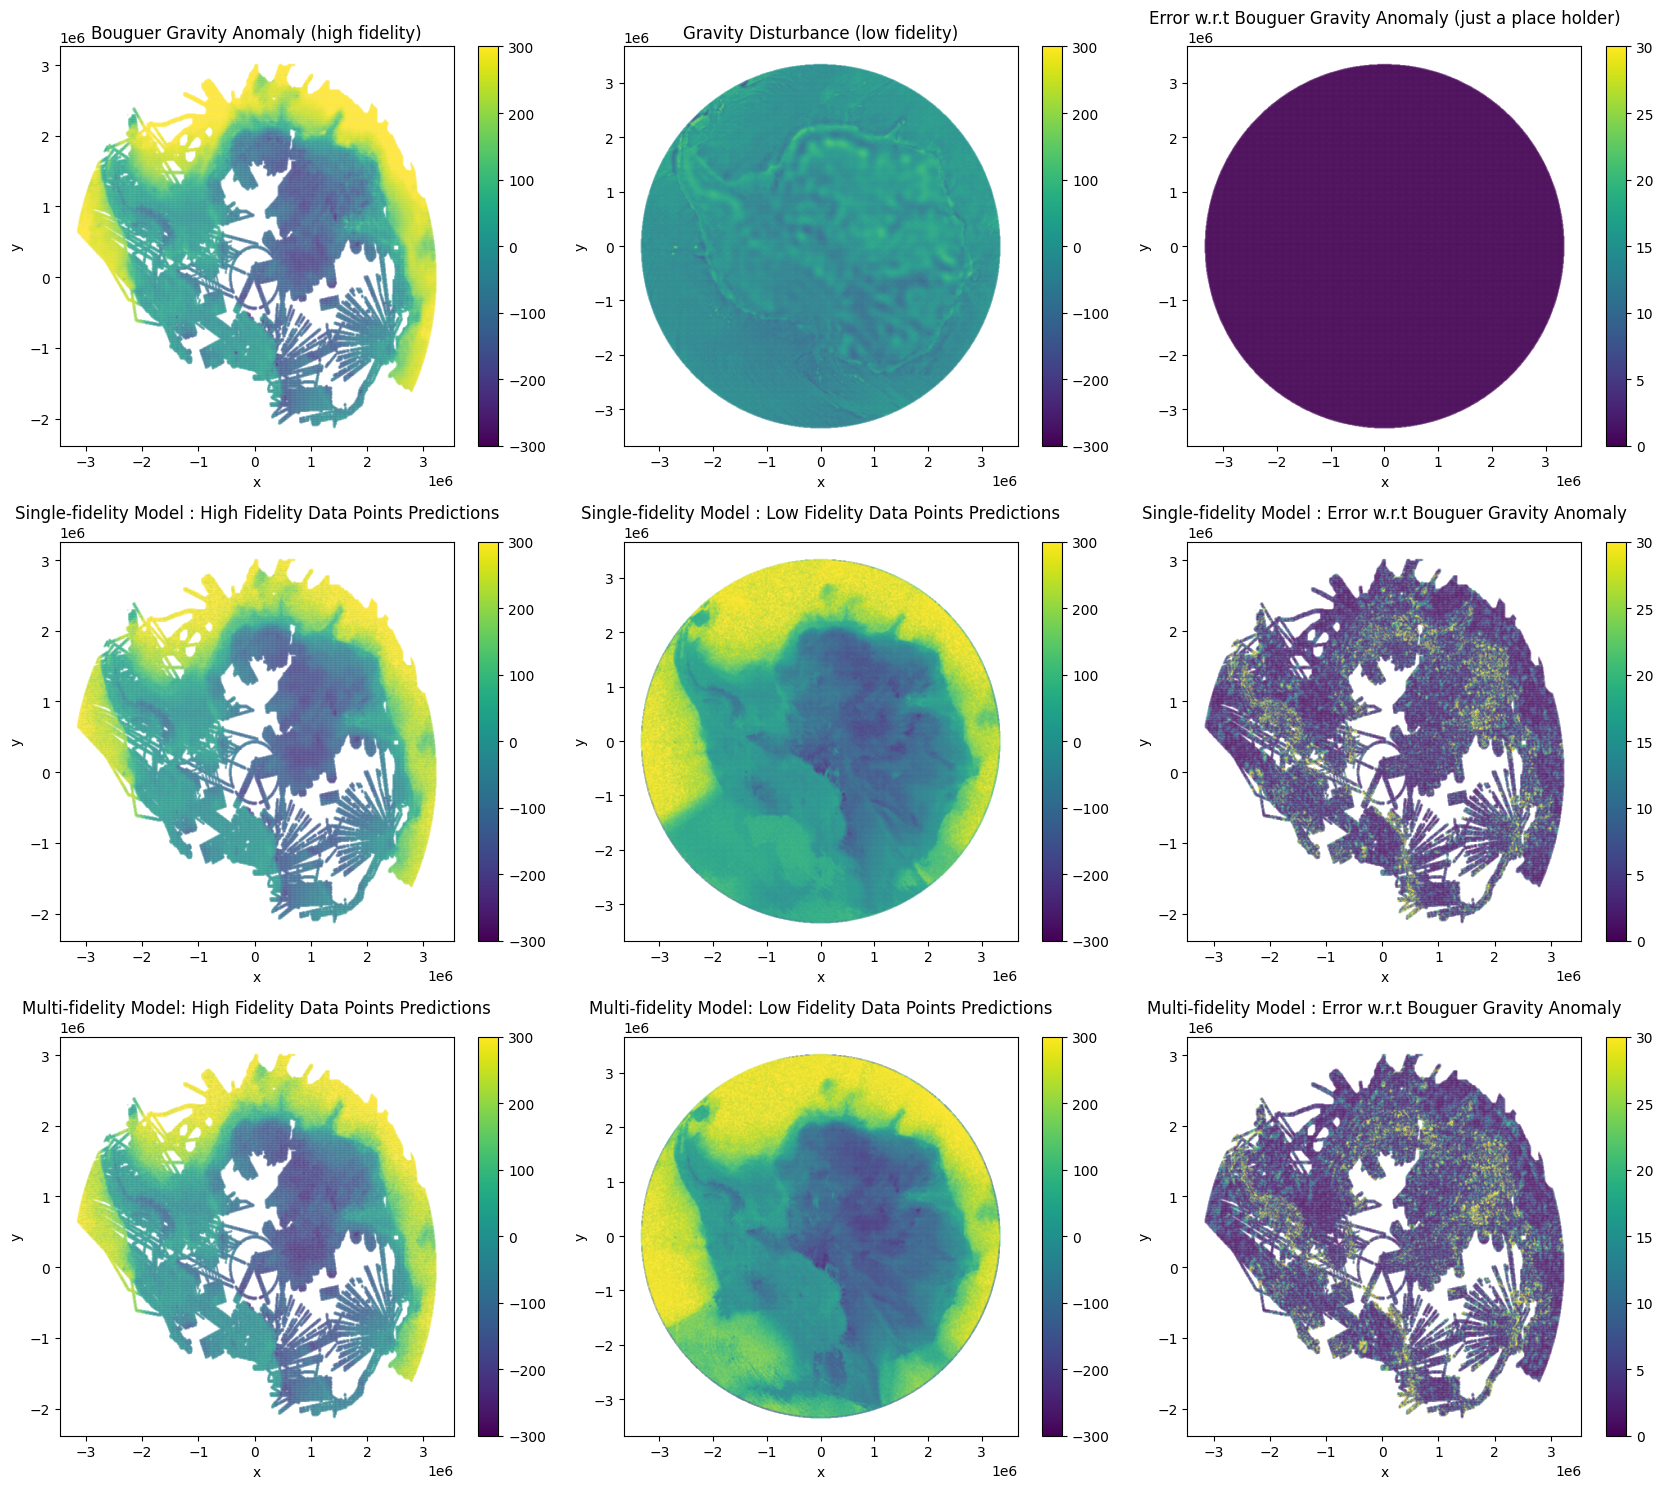

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(17, 15))

# Plot 1: Bouguer Gravity Anomaly
scatter_plot = ax[0, 0].scatter(df_bouguer['x'], df_bouguer['y'], c=df_bouguer['gravity_anomaly'], s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 0])
scatter_plot.set_clim(vmin=-300, vmax=300)
ax[0, 0].set_title('Bouguer Gravity Anomaly (high fidelity)')
ax[0, 0].set_xlabel('x')
ax[0, 0].set_ylabel('y')

# Plot 2: Gravity Disturbance
scatter_plot = ax[0, 1].scatter(df_gravity_disturbance['x'], df_gravity_disturbance['y'], c=df_gravity_disturbance['gravity_disturbance'],  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 1])
scatter_plot.set_clim(vmin=-300, vmax=300)
ax[0, 1].set_title('Gravity Disturbance (low fidelity)')
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('y')

# Plot 3: Error
error = np.sqrt(np.square(df_gravity_disturbance['gravity_disturbance'] - df_gravity_disturbance['gravity_disturbance']))
scatter_plot = ax[0, 2].scatter(df_gravity_disturbance['x'], df_gravity_disturbance['y'], c=error,  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 2])
scatter_plot.set_clim(vmin=0, vmax=30)
ax[0, 2].set_title('Error w.r.t Bouguer Gravity Anomaly (just a place holder)')
ax[0, 2].set_xlabel('x')
ax[0, 2].set_ylabel('y')

# Plot 4: High Fidelity Predictions (Train/Test)
scatter_plot_train = ax[1, 0].scatter(X_high_train[:, 0], X_high_train[:, 1], c=high_fidelity_predictions_train_hf, s=0.01)
scatter_plot_test = ax[1, 0].scatter(X_high_test[:, 0], X_high_test[:, 1], c=high_fidelity_predictions_test_hf, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[1, 0])
scatter_plot_train.set_clim(vmin=-300, vmax=300)
ax[1, 0].set_title('Single-fidelity Model : High Fidelity Data Points Predictions')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('y')

# Plot 5: Low Fidelity Predictions (Train/Test)
scatter_plot_train = ax[1, 1].scatter(X_low_train[:, 0], X_low_train[:, 1], c=low_fidelity_predictions_train_hf, s=0.01)
scatter_plot_test = ax[1, 1].scatter(X_low_test[:, 0], X_low_test[:, 1], c=low_fidelity_predictions_test_hf, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[1, 1])
scatter_plot_train.set_clim(vmin=-300, vmax=300)
ax[1, 1].set_title('Single-fidelity Model : Low Fidelity Data Points Predictions')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('y')

# Plot 6: Error (Train/Test)
error_train = np.sqrt(np.square(high_fidelity_predictions_train_hf - Y_high_train))
error_test = np.sqrt(np.square(high_fidelity_predictions_test_hf - Y_high_test))
mean_error_train = np.mean(error_train)
mean_error_test = np.mean(error_test)
print("Mean Error Single-fidelity Model (Train):", mean_error_train)
print("Mean Error Single-fidelity Model: (Test):", mean_error_test)
scatter_plot_train = ax[1, 2].scatter(X_high_train[:, 0], X_high_train[:, 1], c=error_train, s=0.01)
scatter_plot_test = ax[1, 2].scatter(X_high_test[:, 0], X_high_test[:, 1], c=error_test, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[1, 2])
scatter_plot_train.set_clim(vmin=0, vmax=30)
ax[1, 2].set_title('Single-fidelity Model : Error w.r.t Bouguer Gravity Anomaly')
ax[1, 2].set_xlabel('x')
ax[1, 2].set_ylabel('y')

# Plot 7: Final Predictions (High Fidelity) (Train/Test)
scatter_plot_train = ax[2, 0].scatter(X_high_train[:, 0], X_high_train[:, 1], c=final_predictions_train_high, s=0.01)
scatter_plot_test = ax[2, 0].scatter(X_high_test[:, 0], X_high_test[:, 1], c=final_predictions_test_high, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[2, 0])
scatter_plot_train.set_clim(vmin=-300, vmax=300)
ax[2, 0].set_title('Multi-fidelity Model: High Fidelity Data Points Predictions')
ax[2, 0].set_xlabel('x')
ax[2, 0].set_ylabel('y')

# Plot 8: Final Predictions (Low Fidelity) (Train/Test)
scatter_plot_train = ax[2, 1].scatter(X_low_train[:, 0], X_low_train[:, 1], c=final_predictions_train, s=0.01)
scatter_plot_test = ax[2, 1].scatter(X_low_test[:, 0], X_low_test[:, 1], c=final_predictions_test, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[2, 1])
scatter_plot_train.set_clim(vmin=-300, vmax=300)
ax[2, 1].set_title('Multi-fidelity Model: Low Fidelity Data Points Predictions')
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('y')

# Plot 9: Error (Final Predictions) (Train/Test)
error_train = np.sqrt(np.square(final_predictions_train_high - Y_high_train))
error_test = np.sqrt(np.square(final_predictions_test_high - Y_high_test))
mean_error_train = np.mean(error_train)
mean_error_test = np.mean(error_test)
print("Mean Error Multifidelity Model (Train):", mean_error_train)
print("Mean Error Multifidelity Model: (Test):", mean_error_test)
scatter_plot_train = ax[2, 2].scatter(X_high_train[:, 0], X_high_train[:, 1], c=error_train, s=0.01)
scatter_plot_test = ax[2, 2].scatter(X_high_test[:, 0], X_high_test[:, 1], c=error_test, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[2, 2])
scatter_plot_train.set_clim(vmin=0, vmax=30)
ax[2, 2].set_title('Multi-fidelity Model : Error w.r.t Bouguer Gravity Anomaly')
ax[2, 2].set_xlabel('x')
ax[2, 2].set_ylabel('y')

plt.tight_layout()
plt.show()


With just x, yMean Error Single-fidelity Model (Train): 8.152015Mean Error Single-fidelity Model: (Test): 8.36081Mean Error Multifidelity Model (Train): 8.070912Mean Error Multifidelity Model: (Test): 8.376074
With x,y, bedmapMean Error Single-fidelity Model (Train): 8.801Mean Error Single-fidelity Model: (Test): 9.116Mean Error Multifidelity Model (Train): 9.481Mean Error Multifidelity Model: (Test): 9.712